### **1.0  MariGold Setup**

---



In [ ]:
# @title 💻 1.1 Check CUDA and Python Version (tested with CUDA 12.2 + Python 3.10.12)

# This notebook is supposed to be connected to NVIDIA drivers with CUDA.
# If this doesn't load check that GPU is selected as hardware accelerator under Edit -> Notebook settings.
!nvidia-smi
!python -V

Mon Jul  7 19:09:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# @title 1.2 👆 Select Checkpoint
!pip install ipywidgets==7.7.1 --quiet

from IPython.display import display
import ipywidgets as widgets
import shutil

ckpt_dic = {
    "Original (higher quality)": "prs-eth/marigold-v1-0",
    "LCM (faster)": "prs-eth/marigold-lcm-v1-0",
}

ckpt_name = 'LCM (faster)'
ckpt_path = ckpt_dic[ckpt_name]
w = widgets.Dropdown(
    options=['Original (higher quality)', 'LCM (faster)'],
    value=ckpt_name,
    description='Checkpoint:',
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        ckpt_name = change['new']
        ckpt_path = ckpt_dic[ckpt_name]
        # print(f"Change to checkpoint: {ckpt_name} ({ckpt_path})")

w.observe(on_change)

display(w)
# print(f"{ckpt_path = }")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00


Dropdown(description='Checkpoint:', index=1, options=('Original (higher quality)', 'LCM (faster)'), value='LCM…

In [ ]:
# @title 🔨 1.3 Install dependencies

!pip install --upgrade "diffusers>=0.25.0" --quiet

# !pip install ipywidgets==7.7.1 --quiet


In [ ]:
# @title 🔧 1.4 Setup directories
import os


# Directories
repo_dir = "/content/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")
output_dir_ill = os.path.join(output_dir, "illusions")
output_dir_comp = os.path.join(output_dir, "compressed")


os.makedirs(repo_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_ill, exist_ok=True)
os.makedirs(output_dir_comp, exist_ok=True)

os.chdir(repo_dir)


### **2.0   Get Depth Maps**
---



In [ ]:
# @title 2.1 Functions
import cv2 as cv2
import numpy as np
def resizeAndPad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA

    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = float(w)/h
    saspect = float(sw)/sh

    if (saspect > aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = float(sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0

    elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
        new_w = sw
        new_h = np.round(float(new_w) / aspect).astype(int)
        pad_vert = float(sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img


<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipython-input-5-1657758419.py:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided


In [ ]:
# @title 2.2 Place the images in the /content/Marigold/input folder (run this cell to see buttons)

from IPython.display import display
import ipywidgets as widgets
import shutil
from google.colab import files

button_download = widgets.Button(description="Use sample images")
button_upload = widgets.Button(description="⬆ Upload images")
button_clear_in = widgets.Button(description="♻ Clear input folder")
button_clear_out = widgets.Button(description="♻ Clear output folder")
out_box = widgets.Output()


def on_button_download_clicked(b):
    out_box.clear_output()
    os.chdir(repo_dir)
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)

    with out_box:
        print("downloading sample images")

    # download data
    !wget -nv --show-progress https://share.phys.ethz.ch/~pf/bingkedata/marigold/in-the-wild_example.tar
    # untar
    !tar -xf "in-the-wild_example.tar"
    !rm "in-the-wild_example.tar"
    !mv "in-the-wild_example" "input"

    with out_box:
        print("sample images are downloaded")


def on_button_upload_clicked(b):
    out_box.clear_output()
    os.makedirs(input_dir, exist_ok=True)
    os.chdir(input_dir)
    with out_box:
        uploaded = files.upload()
        image_files = sorted([f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))])
        images=[]
        for file in image_files:
            image = cv2.imread(os.path.join(input_dir, file))

            if max(image.shape)>512:
                print("Image ",file," too large, reducing dimentions")
                x=image.shape[0]
                y=image.shape[1]
                im=resizeAndPad(image, ((x if x<512 else 512),(y if y<512 else 512)), padColor=255)

                cv2.imwrite(os.path.join(input_dir, file), im)

    os.chdir(repo_dir)

def on_button_clear_in_clicked(b):
    out_box.clear_output()
    shutil.rmtree(input_dir)
    os.makedirs(input_dir)
    with out_box:
        print("Input images are cleared")

def on_button_clear_out_clicked(b):
    out_box.clear_output()
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    with out_box:
        print("Output folder is cleared")

button_download.on_click(on_button_download_clicked)
button_upload.on_click(on_button_upload_clicked)
button_clear_in.on_click(on_button_clear_in_clicked)
button_clear_out.on_click(on_button_clear_out_clicked)

widgets.VBox([widgets.HBox([button_upload, button_download]),
              widgets.HBox([button_clear_in, button_clear_out]),
              out_box])


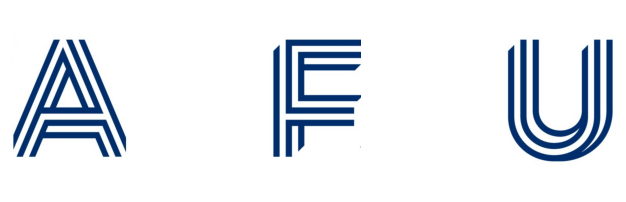

In [ ]:
%matplotlib inline

# @title 2.2.3 Display input images

from glob import glob
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Pre-defined function
def display_images(image_paths, n_images_per_row = 4):
    n_rows = math.ceil(len(image_paths) / n_images_per_row)
    image_files = sorted([f for f in os.listdir(image_paths) if os.path.isfile(os.path.join(image_paths, f))])
    plt.figure(figsize=(10, 2 * n_rows))  # Adjust the size as needed
    for i, img_path in enumerate(image_files):
        img = mpimg.imread(os.path.join(input_dir, img_path))
        plt.subplot(n_rows, n_images_per_row, i + 1)  # Number of rows, number of images per row, current index
        plt.imshow(img)
        plt.axis('off')  # To not display axis

    plt.tight_layout()
    plt.show()


display_images(input_dir)

In [ ]:
# @title 🏇 2.2 Initialize pipeline

# change model cache directory
!export HF_HOME=$(pwd)/checkpoint

from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    ckpt_path,
    custom_pipeline="marigold_depth_estimation"
)

pipe = pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

marigold_depth_estimation.py: 0.00B [00:00, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# @title ▶️ 2.3 Run inference (default settings are for LCM)
denoising_steps = 4 # @param {type:"integer"}
ensemble_size = 5 # @param {type:"integer"}
processing_res = 768 # @param {type:"integer"}
match_input_res = True # @param ["False", "True"]
# use_seed = True # @param ["False", "True"]
# seed = 2024 # @param {type:"integer"}

# if not use_seed:
#     seed = None

import logging
import numpy as np
import torch
from tqdm.auto import tqdm
from glob import glob
from PIL import Image


EXTENSION_LIST = [".jpg", ".jpeg", ".png"]

# Image list
rgb_filename_list = glob(os.path.join(input_dir, "*"))
rgb_filename_list = [
    f for f in rgb_filename_list if os.path.splitext(f)[1].lower() in EXTENSION_LIST
]
rgb_filename_list = sorted(rgb_filename_list)

# Create output folders
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_color, exist_ok=True)
os.makedirs(output_dir_tif, exist_ok=True)
os.makedirs(output_dir_npy, exist_ok=True)

# Run Inference
with torch.no_grad():
    os.makedirs(output_dir, exist_ok=True)

    for rgb_path in tqdm(rgb_filename_list, desc=f"Estimating depth", leave=True):
        # Read input image
        input_image = Image.open(rgb_path)

        # Predict depth
        pipeline_output = pipe(
            input_image,
            denoising_steps=denoising_steps,     # optional
            ensemble_size=ensemble_size,       # optional
            processing_res=processing_res,     # optional
            match_input_res=match_input_res,   # optional
            batch_size=0,           # optional
            color_map="Spectral",   # optional
            show_progress_bar=True, # optional
            # seed=seed,              # optional
        )

        depth_pred: np.ndarray = pipeline_output.depth_np
        depth_colored: Image.Image = pipeline_output.depth_colored

        # Save as npy
        rgb_name_base = os.path.splitext(os.path.basename(rgb_path))[0]
        pred_name_base = rgb_name_base + "_pred"
        npy_save_path = os.path.join(output_dir_npy, f"{pred_name_base}.npy")
        if os.path.exists(npy_save_path):
            logging.warning(f"Existing file: '{npy_save_path}' will be overwritten")
        np.save(npy_save_path, depth_pred)

        # Save as 16-bit uint png
        depth_to_save = (depth_pred * 65535.0).astype(np.uint16)
        png_save_path = os.path.join(output_dir_tif, f"{pred_name_base}.png")
        if os.path.exists(png_save_path):
            logging.warning(f"Existing file: '{png_save_path}' will be overwritten")
        Image.fromarray(depth_to_save).save(png_save_path, mode="I;16")

        # Colorize
        colored_save_path = os.path.join(
            output_dir_color, f"{pred_name_base}_colored.png"
        )
        if os.path.exists(colored_save_path):
            logging.warning(f"Existing file: '{colored_save_path}' will be overwritten")
        depth_colored.save(colored_save_path)

Estimating depth:   0%|          | 0/3 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:619: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx


  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

### **3.0  Illusion Generation**


---
<br>

####**Input Preprocessing:**
<br>


1.   **Convert to Grayscale:**
 This step converts the input image to grayscale, simplifying subsequent processing steps by removing color information.

2.   **Brighten the Mask:**
      1.   **Extract L channel:** LAB color space separates color information into three channels: L (lightness), A (green-red), and B (blue-yellow). By extracting the L channel, we isolate the brightness information.

      2.   **Thresholding:** The brightness component of the mask is thresholded using the Triangle method from the OpenCV (cv2) library. This method determines an optimal threshold value based on the histogram of pixel intensities.

      3.   **Brightening:** The entire mask is then brightened

      4.   **Mask Application:** The original image and the brightened mask are merged, using the thresholded mask to determine which parts of the image need more brightening than others.


####**Illusion Generation Process:**
<br>

1.   **Rotate Image:**
The image is rotated using the nearest mode to prevent distortion at the edges. This replication of the nearest pixels ensures that there's no vignetting effect.

2.   **Second Derivative of Gaussian (DoG) Filter:**
The image undergoes a second derivative of Gaussian filter in the dominant direction. This filter highlights edges and emphasizes fine details in the image. Let's call this G2

3.   **Sobel Filter:**
A Sobel filter is applied to the filtered image(G2) in the dominant direction. Sobel filtering suppresses noise and other low-frequency components helping to remove the artifacts problem we were facing

4.   **Normalization:**
Both the mask and the filtered image(Mask and G2) are normalized to ensure consistent intensity ranges for subsequent operations.

5.   **Hilbert Transform:**
The filtered image undergoes the Hilbert transform, which shifts the phase of the image by 90 degrees. Let's call this H2

6.   **Multiplication and Addition:** The sequence of phase-shifted filters was computed using the following formula:<center>${F}(t) = cos(ωt)G_{2} + sin(ωt)H_{2} $</center>
where F is the phase-shifted filter, ω is the rate of phase shift, and t is time. when


7.   **Normalization:**
The final variable resulting from the multiplication and addition steps is normalized to maintain consistent intensity levels across the image.

8.   **Rotate Back:**
The final variable is rotated back to the original orientation to match the input image's orientation.

####**Video Generation:**
<br>

1.   **Frame Generation:**
The entire process is repeated for multiple frames, generating a sequence of frames for the video.
2.   **Video Creation:**
Using a video writer library, the generated frames are stitched together to create a video.



In [ ]:
# @title 3.1 Libraries
import scipy
from scipy.signal import hilbert
import math
from math import exp,floor
import numpy as np
import cv2

from skimage.exposure import rescale_intensity
from matplotlib import pyplot as plt
import sys
from PIL import Image
from skimage import color
import os
import scipy.ndimage as ndimage
from skimage.color import rgb2lab, lab2rgb

from scipy.ndimage.fourier import fourier_shift

/tmp/ipython-input-11-2668812267.py:18: DeprecationWarning: Please import `fourier_shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.fourier` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.fourier import fourier_shift


In [ ]:
# @title 3.2 Funtions
def rotate_bound(image, angle):

    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


def load_img(path):

    image = cv2.imread(path)
    image = color.rgb2gray(image)
    fheight,fwidth=image.shape
    m=min(fheight,fwidth)
    crop_img = image[0:m, 0:m]

    return image
    #return crop_img

def load_mask(path):

    mask = cv2.imread(path)

    LAB = cv2.cvtColor(mask, cv2.COLOR_BGR2LAB)
    L = LAB[:,:,0]

    # threshold L channel with triangle method
    value, thresh = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)

    # threshold with adjusted value
    value = value + 10
    thresh = cv2.threshold(L, value, 255, cv2.THRESH_BINARY)[1]

    # invert threshold and make 3 channels
    thresh = 255 - thresh
    thresh = cv2.merge([thresh, thresh, thresh])

    gain = 3
    blue = cv2.multiply(mask[:,:,0], gain)
    green = cv2.multiply(mask[:,:,1], gain)
    red = cv2.multiply(mask[:,:,2], gain)
    img_bright = cv2.merge([blue, green, red])

    # blend original and brightened using thresh as mask
    result = np.where(thresh==255, img_bright, mask)

    mask1 = color.rgb2gray(result)
    fheight,fwidth=mask1.shape
    m=min(fheight,fwidth)
    crop_img = mask1[0:m, 0:m]

    return mask1
    #return crop_img


def load_imgWC(path):
    print("Loading image...")

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fheight,fwidth,ch=image.shape
    m=min(fheight,fwidth)
    crop_img = image[0:m, 0:m]
    return crop_img

def generate_video(images,video_name):
    print("Generating video...")
    fheight,fwidth=images[0].shape
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    out = cv2.VideoWriter(video_name,fourcc,60.0, (fwidth,fheight))
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        out.write(gray)


    cv2.destroyAllWindows()
    out.release()

#for the ones with the channels and colors
def generate_video2(images,video_name):
    print("Generating video...")
    fheight,fwidth,channels=images[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    #fourcc = cv2.VideoWriter_fourcc(*'MPEG')
    #fourcc = cv2.VideoWriter_fourcc('h','2','6','4')
    #fourcc = cv2.VideoWriter_fourcc('m','p','4','v')

    out = cv2.VideoWriter(video_name,fourcc,60.0, (fwidth,fheight),isColor=True)
    for image in images:
        img=cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #print(image.shape,img.shape)
        out.write(img)

#         plt.figure(figsize=(20,10))
#         plt.subplot(121), plt.imshow(image), plt.axis('off'), plt.title('Original image', size=20)
#         plt.subplot(122), plt.imshow(img), plt.axis('off'), plt.title('Gray scale image', size=20)
#         plt.show()
    cv2.destroyAllWindows()
    out.release()





In [ ]:
%matplotlib inline

# @title 3.3 Load All Images


#Load all images and masks from the input and output folders

image_files = sorted([f for f in os.listdir(output_dir_tif) if os.path.isfile(os.path.join(output_dir_tif, f))])
masks=[]
print("masks: " ,image_files)

for file in image_files:
    masks.append(load_mask(os.path.join(output_dir_tif, file)))

image_files = sorted([f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))])
images_wc=[]
print("images with color: ", image_files)
for file in image_files:
    images_wc.append(load_imgWC(os.path.join(input_dir, file)))

images=[]
for file in image_files:
    images.append(load_img(os.path.join(input_dir, file)))



print("Input images found: ",len(images)," Masks found: ", len(masks))


masks:  ['a_pred.png', 'f_pred.png', 'u_pred.png']
images with color:  ['a.jpg', 'f.jpeg', 'u.jpeg']
Loading image...
Loading image...
Loading image...
Input images found:  3  Masks found:  3


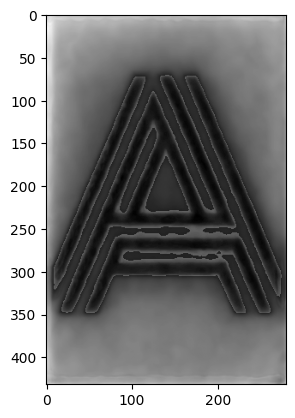

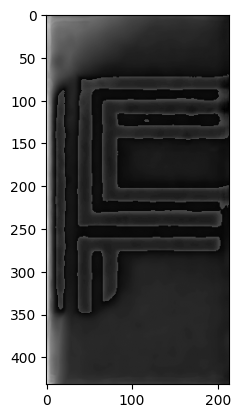

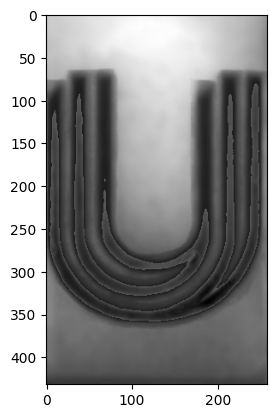

In [ ]:
os.chdir(output_dir_ill)
for i in range(len(images)):

    img=images[i]
    mask=masks[i]
    plt.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
# @title 3.4 Tweakable Parameters
#Tweakable variables
#level of blurr
sigma=0.1
# speed
theta=0.1
#Filter size for sobel filter
filter_size=5
#Direction of movement
angle=0
#Number of frames in the video
number_of_frames=500


In [ ]:
# @title 3.5 Generate Illusion

os.chdir(output_dir_ill)
for j in range(len(images)):

    img=images[j]
    mask=masks[j]
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    image = ndimage.rotate(img, angle,mode="nearest" ,reshape=True)
    mask = ndimage.rotate(mask, angle,mode="nearest" ,reshape=True)


    (cH, cW) = image.shape[:2]
    (iH, iW) = img.shape[:2]

    video_name = image_files[j].rsplit( ".", 1 )[ 0 ]+".mp4"
    frames=[]

    gimg = ndimage.gaussian_filter(image, sigma=sigma, order=[2, 0])
    gimg = cv2.Sobel(gimg,cv2.CV_64F,1,0,ksize=filter_size)

    gimg = cv2.normalize(gimg, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX)
    mask = cv2.normalize(mask, None, alpha=-2, beta=2, norm_type=cv2.NORM_MINMAX)

    himg=np.imag(hilbert(gimg))



    for i in range(1,number_of_frames):

        g2=(np.cos(theta*i))*(mask)*gimg.astype(np.float64)
        h2=(np.sin(theta*i))*himg.astype(np.float64)

        array=g2+h2

        normalized_array = cv2.normalize(array, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        img_array = ((normalized_array) * 255).astype(np.uint8)

        full_img_46= rotate_bound(img_array, angle)
        (cH, cW) = full_img_46.shape[:2]

        left = math.floor((cW-iW)/2)
        top = math.floor((cH-iH)/2)
        right = cW-math.floor((cW-iW)/2)
        bottom = cH-math.floor((cH-iH)/2)

        # Cropped image of above dimension
        # (It will not change original image)
        img_array = full_img_46[left:right,top:bottom]

        frames.append(img_array)

    generate_video(frames,video_name)


Generating video...
Generating video...
Generating video...


In [ ]:
# @title 3.6 Display Illusion
from IPython.display import HTML
from base64 import b64encode
import os

video_files = sorted([f for f in os.listdir(output_dir_ill) if os.path.isfile(os.path.join(output_dir_ill, f))])
videos=[]
html_str="""
<video width=400 controls>
      <source src="{}" type="video/mp4">
</video>
"""
final=""

for file in video_files:
    compressed_path=os.path.join(output_dir_comp, "result_"+file)
    save_path= os.path.join(output_dir_ill, file)


    os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

    # Show video
    mp4 = open(compressed_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    final+=html_str.format(data_url)
HTML(final)
